## Imports and helper functions

In [1]:
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    T2IAdapter,
    MultiAdapter,
    StableDiffusionAdapterPipeline,
    DDPMScheduler
)

import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers.optimization import get_scheduler

/n/home07/adamaraju/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# !pip uninstall diffusers -y

In [3]:
# !pip install .

In [4]:
from types import SimpleNamespace
from datasets import load_dataset

#Generate an arg list 

args = SimpleNamespace()

#Dataset generation args
args.dataset_name = "fusing/fill50k"
args.train_data_dir = None #"../ControlNet/training/fill50k"
args.dataset_config_name=None
args.cache_dir = None
args.image_column = "image"
args.caption_column = "text"
args.conditioning_image_column = "conditioning_image"
args.resolution = 512
args.max_train_samples = 1000
args.seed = None
args.train_batch_size = 4
args.dataloader_num_workers = 0

#Training args
args.num_train_epochs = 200
args.max_train_steps = 1000
args.gradient_accumulation_steps = 1
args.do_classifier_free_guidance= False
args.validation_steps = 1
args.set_grads_to_none = False
#learning rate
args.lr_scheduler = "constant"
args.lr_num_cycles = 1
args.lr_power = 1
args.lr_warmup_steps = 500
args.lr = 1e-5

#Validation args
args.seed = None

#adapter args
args.adapter_conditioning_scale = 1.0
args.num_images_per_prompt = 1

# Generate original training dataset

### Generate base images first

(-0.5, 511.5, 511.5, -0.5)

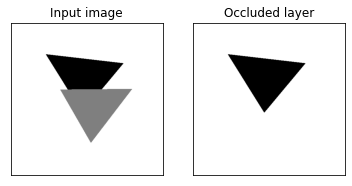

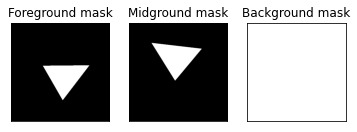

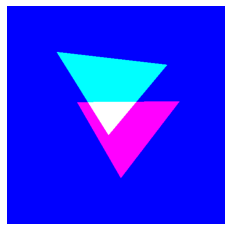

In [5]:
#Generate some generic training data real quick


import numpy as np 
import cv2
import matplotlib.pyplot as plt

def generate_triangle_sdf(H,W):
    
    
    EPS = 1e-12
    x_pos, y_pos = np.meshgrid(np.linspace(0, (H-1), H),np.linspace(0, (W-1), W))

    thresh = int(.2*W)
    len_thresh = thresh*2
    img_np = np.zeros((H, W), dtype=np.uint8)
    valid2 = False
    valid3 = False
    while valid2 == False or valid3 == False:
        x_1 = int(np.random.uniform(thresh,H-thresh))
        y_1 = int(np.random.uniform(thresh,W-thresh))

        #Compute a second point for the triangle
        x_2 = int(np.random.uniform(thresh,H-thresh))
        y_2 = int(np.random.uniform(thresh,W-thresh))
        idx = 0 
        while np.linalg.norm(np.array([x_1,y_1]) - np.array([x_2,y_2])) < len_thresh:
            if idx < 50:
                x_2 = int(np.random.uniform(thresh,H-thresh))
                y_2 = int(np.random.uniform(thresh,W-thresh))
                valid2 = True
            else:
                valid2 = False
                break

        x_3 = int(np.random.uniform(thresh,H-thresh))
        y_3 = int(np.random.uniform(thresh,W-thresh))
        idx = 0
        while (np.linalg.norm(np.array([x_1,y_1]) - np.array([x_3,y_3])) < len_thresh) or (np.linalg.norm(np.array([x_2,y_2]) - np.array([x_3,y_3])) < len_thresh):
            idx = idx +1
            if idx < 50:
                x_3 = int(np.random.uniform(thresh,H-thresh))
                y_3 = int(np.random.uniform(thresh,W-thresh)) 
                valid3 = True
            else:
                valid3 = False
                break
    
    pts_inp = np.array([[x_1, y_1], [x_2, y_2], [x_3, y_3]])
    
    oop_normal = [0,0,1]
    
    n = np.cross([x_1-x_2,y_1-y_2,0], [x_3-x_2,y_3-y_2])
    
    if np.dot(n,oop_normal) < 0:
        pts_inp = pts_inp[[0,2,1],:]
        x_2,y_2 = pts_inp[1,:]
        x_3,y_3 = pts_inp[2,:]
        
    normals = []
    ix_12 = np.linspace(x_1,x_2,500)
    m_12 = (y_2-y_1)/(x_2-x_1 + EPS)
    iy_12 = y_2 + m_12*(ix_12 - x_2)
    out_12 =  np.array([[x, y] for (x, y) in zip(ix_12, iy_12)])
    norm_12 = [np.arctan2(y_2-y_1, x_2-x_1)+np.pi/2] * len(ix_12)
    normals.extend(norm_12)
    
    ix_23 = np.linspace(x_2,x_3,500)
    m_23 = (y_3-y_2)/(x_3-x_2 + EPS)
    iy_23 = y_3 + m_23*(ix_23 - x_3)
    out_23 =  np.array([[x, y] for (x, y) in zip(ix_23, iy_23)])
    norm_23 = [np.arctan2(y_3-y_2, x_3-x_2)+np.pi/2] * len(ix_23)
    normals.extend(norm_23)
    
    ix_31 = np.linspace(x_3,x_1,500)
    m_31 = (y_1-y_3)/(x_1-x_3 + EPS)
    iy_31 = y_1 + m_31*(ix_31 - x_1)
    out_31 =  np.array([[x, y] for (x, y) in zip(ix_31, iy_31)])
    norm_31 = [np.arctan2(y_1-y_3, x_1-x_3)+np.pi/2] * len(ix_31)
    normals.extend(norm_31)
    
    #Combine all 3 ouputs
    out_pts = np.concatenate([out_12,out_23,out_31],axis=0)
    out_pts = out_pts.reshape((1, -1, 2))

    
    pts = pts_inp.reshape((1,-1,2))
    cv2.fillPoly(img_np, pts, color=255, lineType=cv2.LINE_AA)
    img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
    img = np.asarray(img/255.0,dtype=np.float32)
    img = np.asarray(img>.5,dtype=np.float32)
    normals = np.asarray(normals)
    
    return img, out_pts, normals

H=W=512

plt.figure()
plt.subplot(122)
img,out_pts,normals = generate_triangle_sdf(H,W)
img = 1 - img
first_img = (np.repeat(img,3,-1)* 255).astype(np.uint8)
plt.imshow(first_img)
plt.xticks([]); plt.yticks([])
mask_img,_,_ = generate_triangle_sdf(H,W)
mask_img = mask_img[:,:,0].astype(int)
plt.title('Occluded layer')

masked_img = np.copy(img)
masked_img[mask_img==1] = .5


plt.subplot(121)
plt.imshow((np.repeat(masked_img,3,-1)* 255).astype(np.uint8),cmap='gray_r')
plt.xticks([]); plt.yticks([])
plt.title('Input image')

plt.figure()
plt.subplot(131)
fg_layer = mask_img
plt.imshow(fg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);
plt.title('Foreground mask')

plt.subplot(132)
mid_layer = (1-img).squeeze()
plt.imshow(mid_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);
plt.title('Midground mask')

plt.subplot(133)
bg_layer = np.ones(mid_layer.shape)
plt.imshow(bg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);
plt.title('Background mask')

plt.figure()
layer_img = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)
plt.imshow(layer_img)
plt.axis('off')

Text(0.5, 1.0, 'Input image')

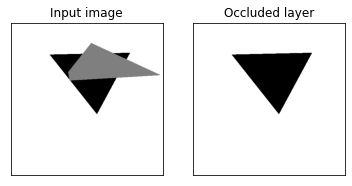

In [6]:
def create_polygon(center, min_radius, max_radius, color=255, H=H,W=W):
    num_sides = 4 # np.random.randint(6, 10)  # Random number of sides between 3 and 10
    angles = [np.random.uniform(0, 1) for _ in range(num_sides)]
    angles = angles /  np.sum(angles) * np.pi *2
    angles = np.cumsum(angles)
    
    
    # Generate random radii for the vertices
    radii = [np.random.uniform(min_radius, max_radius) for _ in range(num_sides)]

    # Calculate the vertex coordinates
    vertices = []
    for i in range(num_sides):
        angle = angles[i]  #
        radius = radii[i]
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        vertices.append((x, y))

    # Close the polygon by connecting the last vertex to the first vertex
    vertices.append(vertices[0])
    
    mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(vertices, dtype=np.int32)], 255)

    
    poly_img = np.zeros((H, W, 3), dtype=np.uint8)
    cv2.fillPoly(poly_img, [np.array(vertices, dtype=np.int32)], color)
    return vertices, mask, poly_img


center = (np.random.uniform(H*.3,H*.7), np.random.uniform(W*.3,W*.7))
min_radius = np.random.uniform(H*.2, H*.3)
max_radius = np.random.uniform(H*.3, H*.4)


plt.figure()
plt.subplot(122)
img,out_pts,normals = generate_triangle_sdf(H,W)
img = 1 - img
first_img = (np.repeat(img,3,-1)* 255).astype(np.uint8)
plt.imshow(first_img)
plt.xticks([]); plt.yticks([])
_,mask_img,_ = create_polygon(center, min_radius, max_radius, H=H,W=W)
mask_img = mask_img.astype(int)/255
plt.title('Occluded layer')
masked_img = np.copy(img)
masked_img[mask_img==1] = .5
plt.subplot(121)
plt.imshow((np.repeat(masked_img,3,-1)* 255).astype(np.uint8),cmap='gray_r')
plt.xticks([]); plt.yticks([])
plt.title('Input image')


In [7]:
DATASET_SIZE=1000
H=W=512

layer_binaries = []
layer_imgs = []
base_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(DATASET_SIZE):
    img,_,_ = generate_triangle_sdf(H,W)
    img = 1- img
    
    #Mask (foreground layer)
    mask_img,_,_ = generate_triangle_sdf(H,W)
    mask_img = mask_img[:,:,0].astype(int)

    #Plain background layer
    bg_layer = np.ones([H,W])
    
    #Compositing full image
    masked_img = np.copy(img)
    masked_img[mask_img==1] = .5
    
    #Compositing layer map
    fg_layer = mask_img
    mid_layer = (1-img).squeeze()
    layer_bin = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)

    #add to lists
    layer_binaries.append(layer_bin)
    layer_imgs.append((gray2rgb(1-fg_layer[...,np.newaxis]*.5),
                       gray2rgb(1-mid_layer[...,np.newaxis]),
                       gray2rgb(bg_layer[...,np.newaxis])))
    base_imgs.append(gray2rgb(masked_img))
    
    if itr%200 == 0:
        print(itr)
    

0
200
400
600
800


In [8]:
# # Also need to generate some utils for the training for the layering maps
# # For example need some code that combines all layer maps below a layer and all above a layer
# # Also need analagous code that does this for the layered  objects in the image

# def get_front_layers(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) -1 #subtract 1 for loops??
#     front_layers = np.ones(layer_imgs[0].shape)
#     front_bin = np.zeros(layer_bin.shape)
#     if layer_no == num_layers:
#         return front_layers,front_bin
#     else:
#         for layer_idx in range(layer_no,num_layers):
#             front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#             front_bin[layer_bin==1] = 1
#         return front_layers,front_bin
        

# def get_back_layer(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) - 1
#     back_layers = np.ones(layer_imgs[0].shape)
#     back_bin = np.zeros(layer_bin.shape)
#     for layer_idx in range(layer_no):
#         #FINISH / FIX THIS CODE AT SOMEPOINT
#         front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#         front_bin[layer_bin==1] = 1
#     return front_layers,front_bin

### Put data into dataset objects

In [9]:
#Define image transforms

image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

conditioning_image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
    ]
)

In [10]:
# Create a dataset class
class LayerDataset(Dataset):
    def __init__(self,base_imgs,layer_imgs):
        self.data = list(zip(base_imgs,layer_imgs))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = 'an image'

        source = item[0]
        target = item[1]*255
        
        #Convert to torch tensors
        source = torch.tensor(source).permute(2,0,1)
        target = torch.tensor(target[1]).permute(2,0,1)
        
        #Apply transforms to both images
        source = conditioning_image_transforms(source)
        target = image_transforms(target)

        return dict(pixel_values=target, txt=prompt, conditioning_pixel_values=source)

In [11]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    # input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        # "input_ids": input_ids,
    }


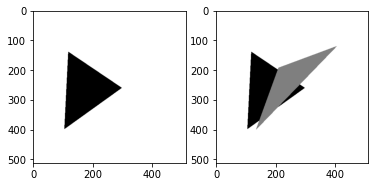

In [12]:
train_dataset =  LayerDataset(base_imgs,layer_imgs)

plt.subplot(121)
plt.imshow(train_dataset[0]['pixel_values'].permute(1,2,0)/ 2 + 1/2)

plt.subplot(122)
plt.imshow(train_dataset[0]['conditioning_pixel_values'].permute(1,2,0))

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

### Create a subset of validation images

In [14]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(VALIDATION_SIZE):
    img,_,_ = generate_triangle_sdf(H,W)
    img = 1- img
    
    #Mask (foreground layer)
    mask_img,_,_ = generate_triangle_sdf(H,W)
    mask_img = mask_img[:,:,0].astype(int)

    #Plain background layer
    bg_layer = np.ones([H,W])
    
    #Compositing full image
    masked_img = np.copy(img)
    masked_img[mask_img==1] = .5
    
    #Compositing layer map
    fg_layer = mask_img
    mid_layer = (1-img).squeeze()
    layer_bin = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)

    #add to lists
    val_binaries.append(layer_bin)
    val_layers.append((gray2rgb(1-fg_layer[...,np.newaxis]*.5),
                       gray2rgb(1-mid_layer[...,np.newaxis]),
                       gray2rgb(bg_layer[...,np.newaxis])))
    val_imgs.append(gray2rgb(masked_img))
    
#     if itr%200 == 0:
#         print(itr)

In [15]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    val_imgs_PIL.append(Image.fromarray(val_imgs[idx]))
    val_layers_PIL.append(Image.fromarray(val_layers[idx][1]))

args.validation_image = val_imgs_PIL
args.validation_prompt = ["picture of an object on a white background"]
args.num_validation_images = VALIDATION_SIZE

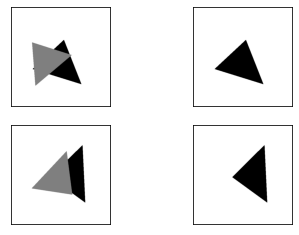

In [16]:
## Hard code some things for getting the first layer of each val_layers for now

plt.subplot(221)
plt.imshow(val_imgs_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(222)
plt.imshow(val_layers_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(223)
plt.imshow(val_imgs_PIL[1])
plt.xticks([]);plt.yticks([]);

plt.subplot(224)
plt.imshow(val_layers_PIL[1])
plt.xticks([]);plt.yticks([]);

In [17]:
# conditioning_image_transforms(np.array(val_imgs_PIL[0]))

# Copying new data generation

In [5]:
import numpy as np
import cv2

def generate_centered_square(H, W, square_side_length):
    # Create a blank image
    image = np.zeros((H, W), dtype=np.uint8)
    
    # Determine the center coordinates
    center_x = W // 2
    center_y = H // 2
    
    # Calculate the start and end coordinates for the square
    start_x = center_x - square_side_length // 2
    start_y = center_y - square_side_length // 2
    end_x = start_x + square_side_length
    end_y = start_y + square_side_length
    
    # Set the square region to ones
    image[start_y:end_y, start_x:end_x] = 1
    
    return image

def generate_centered_triangle(H, W, triangle_side_length):
    # Create a blank image
    image = np.zeros((H, W), dtype=np.uint8)
    
    # Determine the center coordinates
    center_x = W // 2
    center_y = H // 2
    
    # Calculate the half side length of the triangle
    half_side_length = triangle_side_length // 2
    
    # Calculate the three vertex coordinates of the triangle
    vertex1 = (center_x, center_y - half_side_length)
    vertex2 = (center_x - half_side_length, center_y + half_side_length)
    vertex3 = (center_x + half_side_length, center_y + half_side_length)
    
    # Draw the triangle on the image
    points = np.array([vertex1, vertex2, vertex3], np.int32)
    cv2.fillPoly(image, [points], 1)
    
    return image

def generate_centered_circle(H, W, circle_radius):
    # Create a blank image
    image = np.zeros((H, W), dtype=np.uint8)
    
    # Determine the center coordinates
    center_x = W // 2
    center_y = H // 2
    
    # Draw the circle on the image
    cv2.circle(image, (center_x, center_y), circle_radius, 1, thickness=-1)
    
    return image

H = 512
W = 512
square_side_length = 150
triangle_side_length = 150
circle_radius = 100

In [32]:
import torch
import torch.optim as optim
from random import shuffle
# Define the binary maps for the two squares
# You can replace these with your own image data
H = 512
W = 512
image = torch.zeros(H, W, dtype = torch.float32)

# Determine the square dimensions and center coordinates
square_size = 200
center_x = image.size(1) // 2
center_y = image.size(0) // 2

# Calculate the start and end indices for the square
start_x = center_x - square_size // 2
start_y = center_y - square_size // 2
end_x = start_x + square_size
end_y = start_y + square_size

# Set the square region to ones
image[start_y:end_y, start_x:end_x] = 1

im1 = torch.tensor(generate_centered_square(H, W, square_side_length),dtype = torch.float32)
im2 = torch.tensor(generate_centered_triangle(H, W, triangle_side_length),dtype = torch.float32)
im3 = torch.tensor(generate_centered_circle(H, W, circle_radius),dtype = torch.float32)
shapes = [im1,im2,im3]
shuffle(shapes)
#HARD CODE NUMBER OF IMAGES FOR NOW (can easily change later if needed)


from torch.nn import functional as F
def apply_rotation_and_translation(image_tensor, rotation_angle,translation_x,translation_y):
    # Create the affine transformation matrix
    theta = torch.stack([torch.cos(rotation_angle), -torch.sin(rotation_angle),translation_x,
                         torch.sin(rotation_angle), torch.cos(rotation_angle),translation_y]).reshape(2, 3)
    
    # Apply the rotation transformation using grid_sample
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    grid = F.affine_grid(theta.unsqueeze(0), image_tensor.size())
    rotated_image_tensor = F.grid_sample(image_tensor, grid)
    
    return rotated_image_tensor.squeeze(0)

# Define the overlap function
def compute_overlap(im1, im2, rotation, translation_x, translation_y):
    # Apply rotation and translation transformations to square2
    im2_t = apply_rotation_and_translation(im2, rotation,translation_x,translation_y)
    
    # Compute the element-wise intersection of the two squares
    intersection = torch.multiply(im1, im2_t)
    union = im1+im2_t - intersection
    # Compute the overlap as a percentage of the total area
    overlap = intersection.sum() / im1.sum()
    return overlap,union

# Define the loss function
def loss_function(overlap,min=True):
    # Set the target overlap range
    if min:
      target_min = 0.3
    else:
      target_min = 0
    target_max = 0.45

    # Compute the loss using tensor operations
    loss =  (torch.clamp(overlap, target_min, target_max)-overlap)**2
    return loss

# Set the learning rate and number of optimization steps
def space_masks(shapes):
  '''
  Given a list of initial masks, space them out and decide if they are valid
  '''
  NUM_SHAPES = len(shapes)

  # Initialize the rotation and translation parameters
  init_params = torch.rand([NUM_SHAPES-1,3])*.1
  rotation = init_params[:,0].clone().requires_grad_(True)
  translation_x = init_params[:,1].clone().requires_grad_(True)
  translation_y = init_params[:,2].clone().requires_grad_(True)


  learning_rate = .1
  num_steps = 60

  # Create an optimizer
  optimizer = optim.SGD([rotation, translation_x, translation_y], lr=learning_rate)

  # Optimization loop
  valid = False
  for step in range(num_steps):
      overlaps = []
      optimizer.zero_grad() 
      loss = torch.tensor(0.0)
      for idx in range(NUM_SHAPES - 1):
        if idx == 0:
          overlap,union = compute_overlap(shapes[idx], shapes[idx+1], rotation[idx], translation_x[idx], translation_y[idx])
          loss = loss +  loss_function(overlap)
          overlaps.append(overlap.item())
        else:
          for j in range(idx+1):
            overlap,union = compute_overlap(shapes[j], shapes[idx+1], rotation[idx], translation_x[idx], translation_y[idx])
            loss = loss +  loss_function(overlap,(j-idx==1))
            overlaps.append(overlap.item())
      loss.backward()
      optimizer.step()

      # Print the progress
      # if (step % (num_steps/10) == 0):
        # print(f"Step [{step+1}/{num_steps}], Loss: {loss.item()}, Overlap: {overlaps}")
      if loss < 1e-1:
        valid = True
        # print(f"Complete on step {step}, with overlap {overlaps}")
        break
  out_shapes = [shapes[0]]
  for idx in range(NUM_SHAPES - 1):
    out_shapes.append(apply_rotation_and_translation(shapes[idx+1], rotation[idx],translation_x[idx],translation_y[idx])[0,...].detach())
  # for idx in len(out_shapes):
  #   out_shapes[idx] = 1 - out_shapes[idx]
  return out_shapes,valid


# Next step, make random colors, r g and b for the three shapes and assign them

import torch
import torch.nn.functional as F

def color_mask(binary_mask, color):
    """
    Fill a binary mask with the specified color.

    Args:
        binary_mask (torch.Tensor): Binary mask tensor of shape (H, W) where H is the height and W is the width.
        color (str): Candidate color - 'red', 'green', or 'blue'.

    Returns:
        torch.Tensor: Image tensor of shape (3, H, W) with the filled color based on the binary mask.
    """
    # Validate the color input
    valid_colors = ['red', 'green', 'blue']
    if color not in valid_colors:
        raise ValueError("Invalid color. Choose from 'red', 'green', or 'blue'.")

    # Expand the binary mask to have 3 channels for RGB
    mask_rgb = binary_mask.unsqueeze(0).repeat(3, 1, 1)
    
    # Change the type of the images from solid color to wavy
    # Create a grid of size 512x512
    x, y = np.meshgrid(np.arange(512), np.arange(512))

    # Define the wavelength and angles
    wavelength = 64
    angles = [45, 90, 135, 180]

    # Initialize an empty list to store the sinusoid arrays
    sinusoid_arrays = []
    
    angle = angles[random.randint(0, 3)]
    # Generate sinusoids for each angle
    theta = np.radians(angle)

    # Compute the sinusoid
    sinusoid = (np.sin(2 * np.pi * (x * np.cos(theta) + y * np.sin(theta)) / wavelength) + 2)/3

    # Define the color channels
    if color == 'red':
        color_channels = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32).view(3, 1, 1)
    elif color == 'green':
        color_channels = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32).view(3, 1, 1)
    else:  # color == 'blue'
        color_channels = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float32).view(3, 1, 1)

    # Fill the mask with the specified color
    filled_image = mask_rgb * color_channels*sinusoid + 1-mask_rgb

    return filled_image


import random

def generate_canonical_shapes():
  H = 512
  W = 512
  square_side_length = 150
  triangle_side_length = 150
  circle_radius = 100

  im1 = torch.tensor(generate_centered_square(H, W, square_side_length),dtype = torch.float32)
  im2 = torch.tensor(generate_centered_triangle(H, W, triangle_side_length),dtype = torch.float32)
  im3 = torch.tensor(generate_centered_circle(H, W, circle_radius),dtype = torch.float32)
  shapes = [im1,im2,im3]
  random.shuffle(shapes)
  NUM_SHAPES = 2
  masks, valid = space_masks(shapes)
  if not valid:
    print("invalid!")
  final_out = None
  colors = ['red','green','blue']
  polygons = []
  random.shuffle(colors)
  for idx in np.arange(NUM_SHAPES):
    if final_out == None:
      polygon = color_mask(masks[idx],colors[idx])
      polygons.append(polygon.clone().permute(1,2,0))
      final_out = polygon
    else:
      bool_tensor = masks[idx]>.5
      polygon = color_mask(masks[idx],colors[idx])
      polygons.append(polygon.permute(1,2,0))
      final_out[:,bool_tensor] = polygon[:,bool_tensor]

  final_out = final_out.permute(1,2,0)
  return final_out,[mask.unsqueeze(-1) for mask in masks],polygons


In [33]:
DATASET_SIZE=10
H=W=512

layer_binaries = []
layer_imgs = []
base_imgs = []

for itr in range(DATASET_SIZE):
    img,masks,polygons = generate_canonical_shapes()
    
    layer_binaries.append(masks)
    layer_imgs.append(polygons)
    base_imgs.append(img)
    # print(itr)
    if itr%200 == 0:
        print(itr)

0


In [34]:
def combine_masks(binary_masks, index):
    '''
    input: binary_masks, size B x Layers x C x H x W
    '''
    
    combined_list = []
    for batch_id in range(binary_masks.shape[0]):
        combined_mask = torch.zeros_like(binary_masks[0,0,...], dtype=torch.uint8)
        for i in range(index):
            combined_mask = torch.logical_or(combined_mask, binary_masks[batch_id,i,...])
        combined_list.append(combined_mask)
    return torch.stack(combined_list)


# combined_mask = combine_masks(torch.tensor(masks).squeeze().unsqueeze(0),2)

# plt.imshow(combined_mask.squeeze(),cmap='gray')

In [35]:
plt.imshow(img)

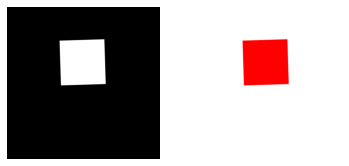

In [10]:
from matplotlib import pyplot as plt
for mask,polygon in zip(masks,polygons):
    plt.figure()
    plt.subplot(121)
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(polygon)
    plt.axis('off')

In [10]:
# # Also need to generate some utils for the training for the layering maps
# # For example need some code that combines all layer maps below a layer and all above a layer
# # Also need analagous code that does this for the layered  objects in the image

# def get_front_layers(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) -1 #subtract 1 for loops??
#     front_layers = np.ones(layer_imgs[0].shape)
#     front_bin = np.zeros(layer_bin.shape)
#     if layer_no == num_layers:
#         return front_layers,front_bin
#     else:
#         for layer_idx in range(layer_no,num_layers):
#             front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#             front_bin[layer_bin==1] = 1
#         return front_layers,front_bin
        

# def get_back_layer(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) - 1
#     back_layers = np.ones(layer_imgs[0].shape)
#     back_bin = np.zeros(layer_bin.shape)
#     for layer_idx in range(layer_no):
#         #FINISH / FIX THIS CODE AT SOMEPOINT
#         front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#         front_bin[layer_bin==1] = 1
#     return front_layers,front_bin

### Put data into dataset objects

In [52]:
#Define image transforms

image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

conditioning_image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
    ]
)

In [53]:
# Create a dataset class
class LayerDataset(Dataset):
    def __init__(self,base_imgs,layer_imgs,layer_binaries):
        self.data = list(zip(base_imgs,layer_imgs,layer_binaries))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = 'an object on a black background'

        source = item[0] #original (base) image
        targets = item[1] #Layerwise images
        masks = item[2] #Layerwise black and white binaries
        
        #Convert to torch tensors and apply image transforms
        source = torch.tensor(source).permute(2,0,1)
        source = conditioning_image_transforms(source)

        target_list = []
        for target in targets:
            target_list.append(image_transforms(255*torch.tensor(target).permute(2,0,1)))
        target_tensor = torch.stack(target_list)
        
        mask_list = []
        for mask in masks:
            mask_list.append(conditioning_image_transforms(255*torch.tensor(mask).permute(2,0,1)))
        mask_tensor = torch.stack(mask_list)

        return dict(pixel_values=target_tensor, pixel_binaries =mask_tensor,  txt=prompt, conditioning_pixel_values=source)

In [54]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    pixel_binaries = torch.stack([example["pixel_binaries"] for example in examples])
    pixel_binaries = pixel_binaries.to(memory_format=torch.contiguous_format).float()
    # input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "pixel_binaries": pixel_binaries,
        # "input_ids": input_ids,
    }


In [55]:
train_dataset =  LayerDataset(base_imgs,layer_imgs,layer_binaries)

# plt.subplot(121)
# plt.imshow(train_dataset[0]['pixel_values'].permute(1,2,0)/ 2 + 1/2)

# plt.subplot(122)
# plt.imshow(train_dataset[0]['conditioning_pixel_values'].permute(1,2,0))

In [56]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

### Create a subset of validation images

In [57]:
!nvidia-smi

Tue Aug  8 13:32:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:31:00.0 Off |                    0 |
| N/A   26C    P0              68W / 500W |  25750MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [60]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

for itr in range(VALIDATION_SIZE):
    img,masks,polygons = generate_canonical_shapes()
    
    #add to lists
    val_binaries.append(masks)
    val_layers.append(polygons)
    val_imgs.append(img)
    
#     if itr%200 == 0:
#         print(itr)

In [61]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    rint = 0#np.random.randint(0,3)
    val_imgs_PIL.append(Image.fromarray((val_imgs[idx]*255).numpy().astype(np.uint8)))
    # val_imgs_PIL.append([Image.fromarray((val_imgs[idx]*255).numpy().astype(np.uint8)), Image.fromarray((val_binaries[idx][rint]*255).repeat(1,1,3).numpy().astype(np.uint8))])
    val_layers_PIL.append(Image.fromarray(255*val_layers[idx][rint].numpy().astype(np.uint8)))
    
transform = transforms.Compose([transforms.PILToTensor()])
# transform = transforms.Grayscale(3)
val_set = []
for imgs in val_imgs_PIL:
    val_set.append(imgs)
    # val_set.append(torch.cat([transform(img) for img in imgs],dim=0).unsqueeze(0))
    
args.validation_image = val_set
args.validation_prompt = ["picture of an object on a black background"]
args.num_validation_images = VALIDATION_SIZE

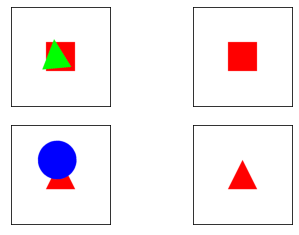

In [62]:
## Hard code some things for getting the first layer of each val_layers for now

plt.subplot(221)
plt.imshow(val_set[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(222)
plt.imshow(val_layers_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(223)
plt.imshow(val_set[1])
plt.xticks([]);plt.yticks([]);

plt.subplot(224)
plt.imshow(val_layers_PIL[1])
plt.xticks([]);plt.yticks([]);

# Training Code

## Implement the adapter models

In [63]:
import torch
import torch.nn as nn

## Network that takes 4 dimensional input and pushes it to 3 dimensions for the vae
class ContractNet(nn.Module):
    def __init__(self):
        super(ContractNet, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

    

## Network that takes 3 dimensional input and pushes it to 4 dimensions for model out
class ExpandNet(nn.Module):
    def __init__(self):
        super(ExpandNet, self).__init__()
        self.conv = nn.Conv2d(3, 4, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [64]:
#Instantiate the two adapters and the pretrained model

# An adapter that takes in the original image (or a subset of layers)
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(1), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter
# adapter = MultiAdapter([RGB_adapter,mask_adapter])
adapter = RGB_adapter

#Instantiate the Convolutional layers
# contract_layer = ContractNet()
# expand_layer = ExpandNet()

#Pretrained stable diffusion model that we will try not to touch (may end up changing the final conv_out though.
#To be honest I am really hoping this works

model_name = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionAdapterPipeline.from_pretrained(model_name, torch_dtype=torch.float32).to('cuda')
pipe.safety_checker = None

vae = pipe.vae
unet = pipe.unet
noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

## Not sure, do i turn off gradients for these networks? Probaly not in my optinion
# vae.requires_grad_(False)
# unet.requires_grad_(False)
# text_encoder.requires_grad_(False)
# also get the clip model because it matters probably....

#But looks like it may not work as just the model for training so we have to separate it into parts for training anyway

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [65]:
#Random point, what if I dont do anything about the masking etc, and just try and make a model that removes the top object in a scene, or like just tries to get the layer mappings?

## Train the model

### TODO: Write a validation loop

In [68]:
def log_validation(pipe, adapter, args, step=0,accelerator=None):
    print(f"step = {step}")

    # controlnet = accelerator.unwrap_model(controlnet)

    pipe.adapter = adapter
    # pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    # pipeline = pipeline.to(accelerator.device)
    # pipeline.set_progress_bar_config(disable=True)

#     if args.enable_xformers_memory_efficient_attention:
#         pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if len(args.validation_image) == len(args.validation_prompt):
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt
    elif len(args.validation_image) == 1:
        validation_images = args.validation_image * len(args.validation_prompt)
        validation_prompts = args.validation_prompt
    elif len(args.validation_prompt) == 1:
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt * len(args.validation_image)
    else:
        raise ValueError(
            "number of `args.validation_image` and `args.validation_prompt` should be checked in `parse_args`"
        )

    image_logs = []

    for validation_prompt, validation_image in zip(validation_prompts, validation_images):
        # validation_image = Image.open(validation_image).convert("RGB")

        images = []

        for _ in range(args.num_validation_images):
            with torch.autocast("cuda"):
                image = pipe(
                    validation_prompt, validation_image, num_inference_steps=20, generator=generator,adapter_weighting = [1.0,0.0]
                ).images[0]

            images.append(image)

        image_logs.append(
            {"validation_image": validation_image, "images": images, "validation_prompt": validation_prompt}
        )
    return image_logs

# Here I need to make a set of images 
# Looks like top row, validation image *2, next validation image *2, bottom row is outputs

def save_image_logs(image_logs,step=0):
    plt.figure()
    plt.subplot(241)
    plt.imshow(image_logs[0]['validation_image'])
    plt.subplot(242)
    plt.imshow(image_logs[0]['validation_image'])
    plt.subplot(243)
    plt.imshow(image_logs[1]['validation_image'])
    plt.subplot(244)
    plt.imshow(image_logs[1]['validation_image'])

    plt.subplot(245)
    plt.imshow(image_logs[0]['images'][0])
    plt.subplot(246)
    plt.imshow(image_logs[0]['images'][1])
    plt.subplot(247)
    plt.imshow(image_logs[1]['images'][0])
    plt.subplot(248)
    plt.imshow(image_logs[1]['images'][1])

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

    plt.savefig(f'test_logs/debug_tests/unet_optim_epoch_{step}_val.png')

### Actual training loop

In [48]:
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(1), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter
# adapter = MultiAdapter([RGB_adapter,mask_adapter])
adapter = RGB_adapter

In [69]:
#Put adapter on GPU
adapter = adapter.to("cuda")
adapter.train()

#Set optimizer class
optimizer_class = torch.optim.AdamW

#Get parameters to optimize
params_to_optimize = adapter.parameters()
optimizer = optimizer_class(
    params_to_optimize,
    lr = args.lr
) 

#adding in a new optimizer for the u-net
unet_optim = optimizer_class(
    unet.parameters(),
    lr = args.lr * .1
) 

#Get lr scheduler = 
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,# * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps,# * args.gradient_accumulation_steps,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# additional, try to figure out accelerator

In [70]:
vae.requires_grad_(False);
# unet.requires_grad_(False);

***** Running training *****
  Num examples = 200
  Num batches each epoch = 50
  Num Epochs = 200
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 10000


Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-53-b3266674a631>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source).permute(2,0,1)
<ipython-input-53-b3266674a631>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_list.append(image_transforms(255*torch.tensor(target).permute(2,0,1)))
<ipython-input-53-b3266674a631>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_list.append(conditioning_image_transforms(255*torch.tensor(mask).permute(2,0,1)))


{'loss': 0.0001719822466839105, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002826831769198179, 'lr': 1e-05}
{'loss': 0.0007124622352421284, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 6.955359276616946e-05, 'lr': 1e-05}
{'loss': 0.0004127850115764886, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001781773316906765, 'lr': 1e-05}
{'loss': 0.0003671304148156196, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002113230002578348, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00018391790217719972, 'lr': 1e-05}
{'loss': 0.001461321720853448, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010619391105137765, 'lr': 1e-05}
{'loss': 0.00012127517402404919, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00013520006905309856, 'lr': 1e-05}
{'loss': 8.393511961912736e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00022767664631828666, 'lr': 1e-05}
{'loss': 4.521630398812704e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.401789480354637e-05, 'lr': 1e-05}
{'loss': 0.0006908635259605944, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.488187788520008e-05, 'lr': 1e-05}
{'loss': 0.0017472445033490658, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.24339731479995e-05, 'lr': 1e-05}
{'loss': 0.0006982093909755349, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006051082164049149, 'lr': 1e-05}
{'loss': 6.596343882847577e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.71892710973043e-05, 'lr': 1e-05}
{'loss': 0.00022076923050917685, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6124291252926923e-05, 'lr': 1e-05}
{'loss': 6.511744868475944e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00015678002091590315, 'lr': 1e-05}
{'loss': 6.400154961738735e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.259132063249126e-05, 'lr': 1e-05}
{'loss': 5.364088428905234e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.637767647684086e-05, 'lr': 1e-05}
{'loss': 1.6493124348926358e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.983603427419439e-05, 'lr': 1e-05}
{'loss': 7.923644443508238e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.7342564105056226e-05, 'lr': 1e-05}
{'loss': 7.055275636957958e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-68-bff519b4a7f0>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


{'loss': 4.440695192897692e-05, 'lr': 1e-05}
{'loss': 0.00012252596206963062, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.2236999433953315e-05, 'lr': 1e-05}
{'loss': 6.943597691133618e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.000249176227953285, 'lr': 1e-05}
{'loss': 3.494141128612682e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011810289288405329, 'lr': 1e-05}
{'loss': 2.5393224859726615e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.7581927497521974e-05, 'lr': 1e-05}
{'loss': 3.0192046324373223e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.321732452197466e-05, 'lr': 1e-05}
{'loss': 0.0021191961131989956, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8329104932490736e-05, 'lr': 1e-05}
{'loss': 0.00031644522096030414, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.000664039165712893, 'lr': 1e-05}
{'loss': 0.00012414599768817425, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 6.803238647989929e-05, 'lr': 1e-05}
{'loss': 8.60363434185274e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.971419159322977e-05, 'lr': 1e-05}
{'loss': 4.648649337468669e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.290673678042367e-05, 'lr': 1e-05}
{'loss': 6.152989226393402e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002057382371276617, 'lr': 1e-05}
{'loss': 9.539890743326396e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0015880330465734005, 'lr': 1e-05}
{'loss': 3.1496801966568455e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4531309463782236e-05, 'lr': 1e-05}
{'loss': 0.00011339330376358703, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.738505468703806e-05, 'lr': 1e-05}
{'loss': 2.2599910153076053e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.4119839256163687e-05, 'lr': 1e-05}
{'loss': 8.854541374603286e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.3916530810529366e-05, 'lr': 1e-05}
{'loss': 3.555728471837938e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001280001160921529, 'lr': 1e-05}
{'loss': 1.4195697076502256e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00024190849217120558, 'lr': 1e-05}
{'loss': 0.00048076946404762566, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002800371148623526, 'lr': 1e-05}
{'loss': 2.6942638214677572e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.580464155878872e-05, 'lr': 1e-05}
{'loss': 1.339650134468684e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.037873052060604e-05, 'lr': 1e-05}
{'loss': 2.2763890228816308e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002970429486595094, 'lr': 1e-05}
{'loss': 2.894521639973391e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.371854786062613e-05, 'lr': 1e-05}
{'loss': 7.118171197362244e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00016413845878560096, 'lr': 1e-05}
{'loss': 5.237556979409419e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4670087441336364e-05, 'lr': 1e-05}
{'loss': 5.644269913318567e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.7297781091183424e-05, 'lr': 1e-05}
{'loss': 2.4902263248804957e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3336175217991695e-05, 'lr': 1e-05}
{'loss': 1.7182057490572333e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.22815888770856e-05, 'lr': 1e-05}
{'loss': 4.102067759959027e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.465175879886374e-05, 'lr': 1e-05}
{'loss': 3.571058186935261e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.212424780940637e-05, 'lr': 1e-05}
{'loss': 2.4718647182453424e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4353739970829338e-05, 'lr': 1e-05}
{'loss': 2.933064752141945e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.762085442664102e-05, 'lr': 1e-05}
{'loss': 0.00013673037756234407, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4984237825265154e-05, 'lr': 1e-05}
{'loss': 8.786236867308617e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.196280057542026e-05, 'lr': 1e-05}
{'loss': 7.156022184062749e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00018554850248619914, 'lr': 1e-05}
{'loss': 6.499294249806553e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.000512380269356072, 'lr': 1e-05}
{'loss': 8.170436922227964e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1445834388723597e-05, 'lr': 1e-05}
{'loss': 3.4663797123357654e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001914698805194348, 'lr': 1e-05}
{'loss': 0.000685057369992137, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011932053894270211, 'lr': 1e-05}
{'loss': 0.00019794315448962152, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2850051462010015e-05, 'lr': 1e-05}
{'loss': 5.4812491725897416e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8236610887688585e-05, 'lr': 1e-05}
{'loss': 0.00017294951248914003, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 6.992119597271085e-05, 'lr': 1e-05}
{'loss': 1.8689112039282918e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.076162728480995e-05, 'lr': 1e-05}
{'loss': 3.1548875995213166e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.706002512946725e-05, 'lr': 1e-05}
{'loss': 0.0006322109838947654, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.300192373804748e-05, 'lr': 1e-05}
{'loss': 2.289724216097966e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3072056137607433e-05, 'lr': 1e-05}
{'loss': 0.00020067390869371593, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.622713848017156e-05, 'lr': 1e-05}
{'loss': 1.637804598431103e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.444151323288679e-05, 'lr': 1e-05}
{'loss': 1.643044743104838e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7868936993181705e-05, 'lr': 1e-05}
{'loss': 3.4724853321677074e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.229569483664818e-05, 'lr': 1e-05}
{'loss': 0.00014071166515350342, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4260214811656624e-05, 'lr': 1e-05}
{'loss': 4.550749872578308e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5823130272328854e-05, 'lr': 1e-05}
{'loss': 1.6602831237833016e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00028442565235309303, 'lr': 1e-05}
{'loss': 3.1689429306425154e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.965420132270083e-05, 'lr': 1e-05}
{'loss': 5.4940472182352096e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.458025771076791e-05, 'lr': 1e-05}
{'loss': 4.028570401715115e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6860012692632154e-05, 'lr': 1e-05}
{'loss': 9.562834748066962e-06, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0003108651435468346, 'lr': 1e-05}
{'loss': 2.8081502023269422e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00013033283175900578, 'lr': 1e-05}
{'loss': 8.31143552204594e-06, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3345517800189555e-05, 'lr': 1e-05}
{'loss': 5.6778008001856506e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.262389484210871e-05, 'lr': 1e-05}
{'loss': 1.817327574826777e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:120                                                                                  │
│ in save_image_logs:78                                                                            │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/pyplot.py:859 in savefig                                                               │
│                                                                                                  │
│    856 @_copy_docstring_and_deprecators(Figure.savefig)                                          │
│    857 def savefig(*args, **kwargs):                                                             │
│    858 │   fig = gcf()                                                                           │
│ ❱  859 │   res = fig.savefig(*args, **kwargs)                                                    │
│    860 │   fig.canvas.draw_idle()   # need this if 'transparent=True' to reset colors            │
│    861 │   return res                                                                            │
│    862                                                                                           │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/figure.py:2311 in savefig                                                              │
│                                                                                                  │
│   2308 │   │   │   │   patch.set_facecolor('none')                                               │
│   2309 │   │   │   │   patch.set_edgecolor('none')                                               │
│   2310 │   │                                                                                     │
│ ❱ 2311 │   │   self.canvas.print_figure(fname, **kwargs)                                         │
│   2312 │   │                                                                                     │
│   2313 │   │   if transparent:                                                                   │
│   2314 │   │   │   for ax, cc in zip(self.axes, original_axes_colors):                           │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/backend_bases.py:2210 in print_figure                                                  │
│                                                                                                  │
│   2207 │   │   │   │   _bbox_inches_restore = None                                               │
│   2208 │   │   │                                                                                 │
│   2209 │   │   │   try:                                                                          │
│ ❱ 2210 │   │   │   │   result = print_method(                                                    │
│   2211 │   │   │   │   │   filename,                                                             │
│   2212 │   │   │   │   │   dpi=dpi,                                                              │
│   2213 │   │   │   │   │   facecolor=facecolor,                                                  │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/backend_bases.py:1639 in wrapper                                                       │
│                                                            

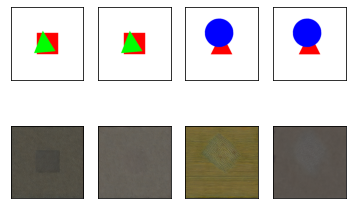

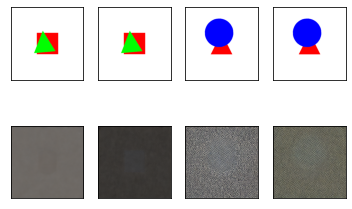

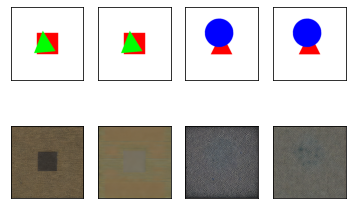

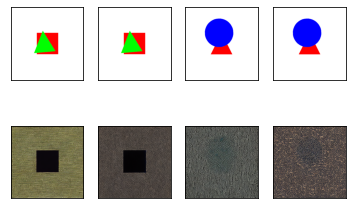

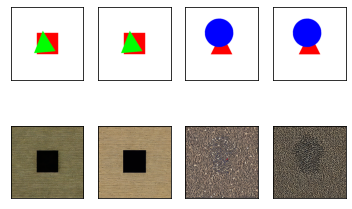

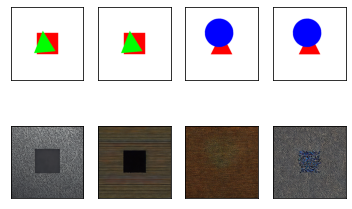

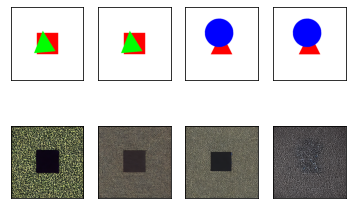

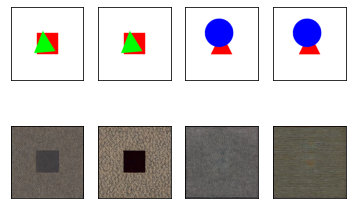

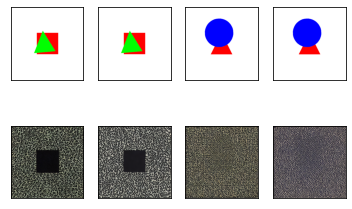

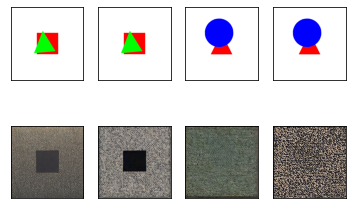

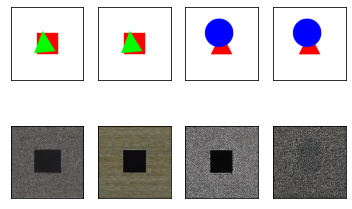

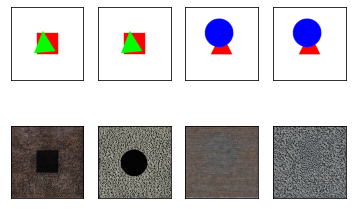

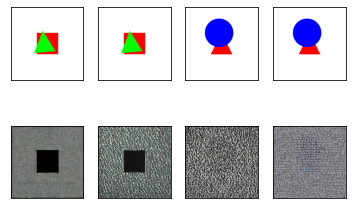

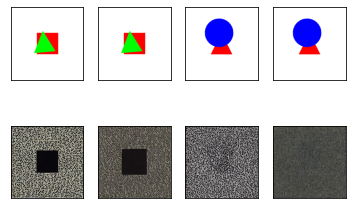

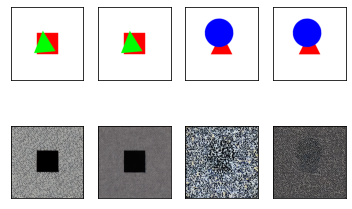

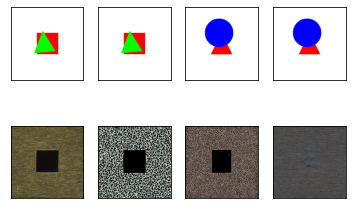

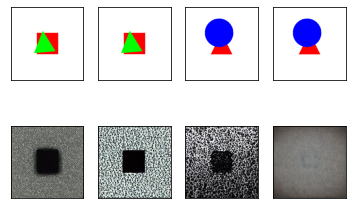

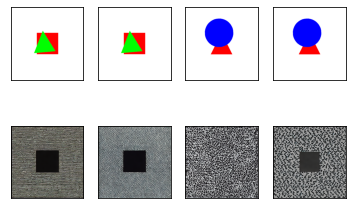

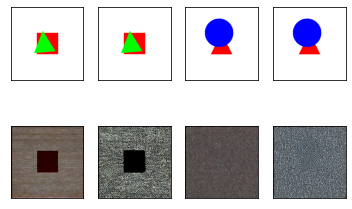

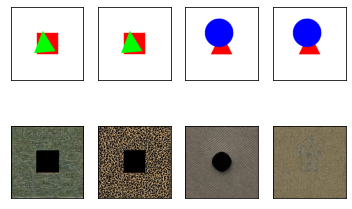

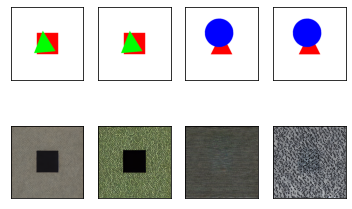

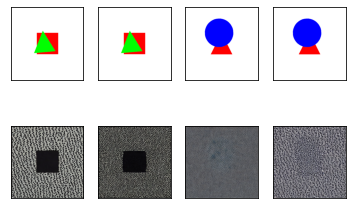

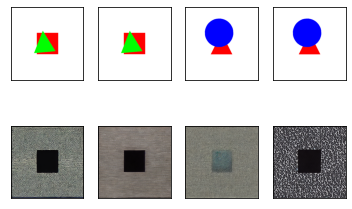

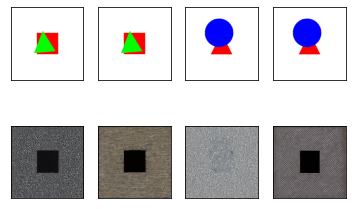

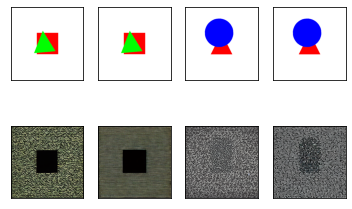

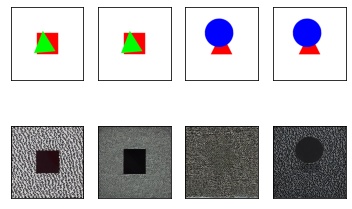

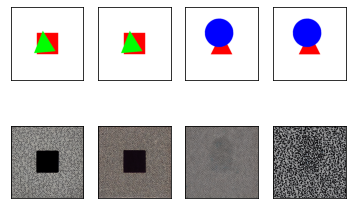

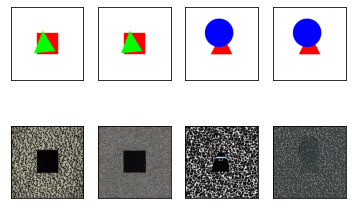

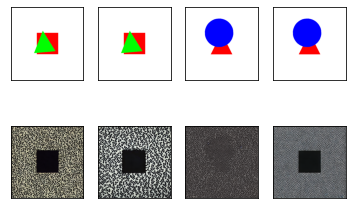

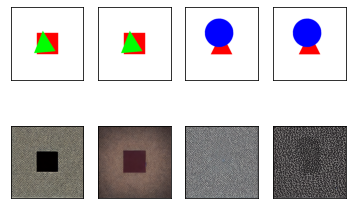

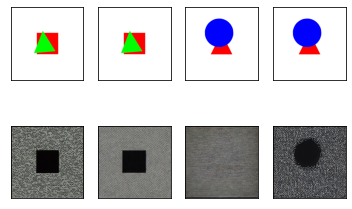

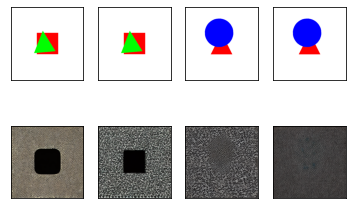

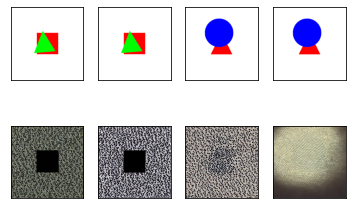

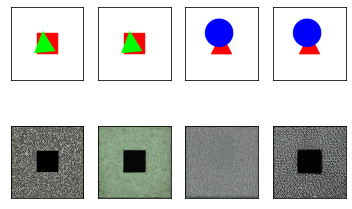

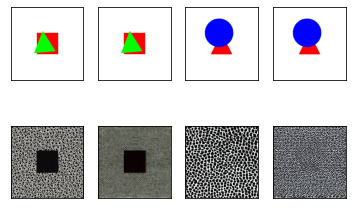

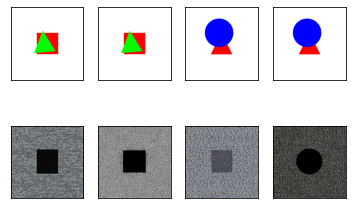

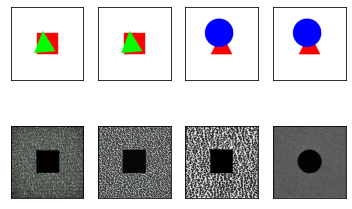

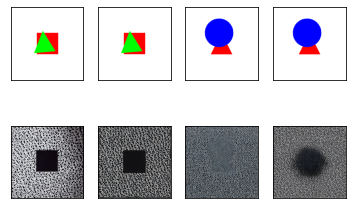

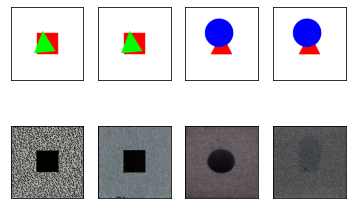

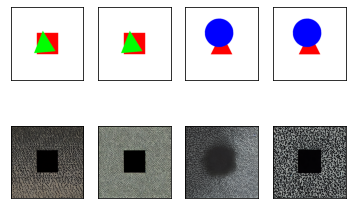

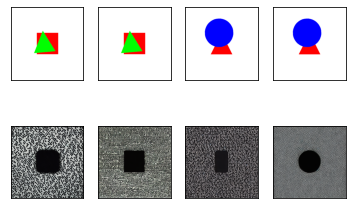

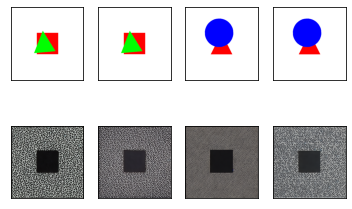

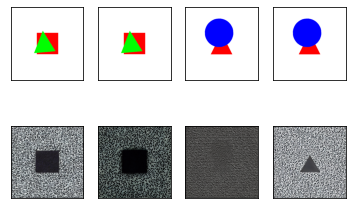

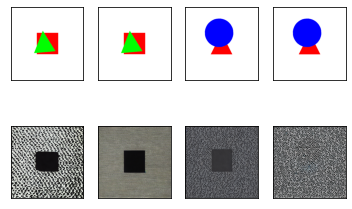

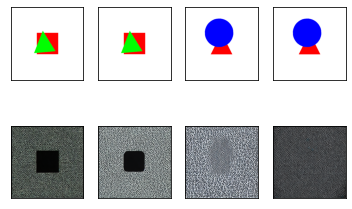

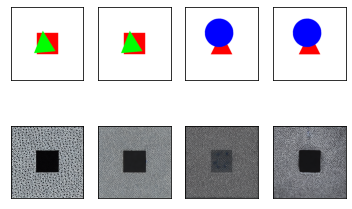

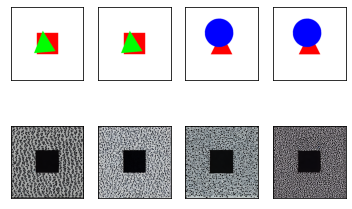

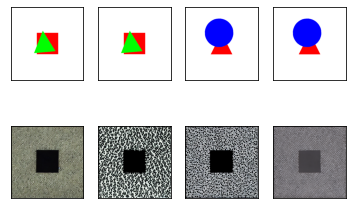

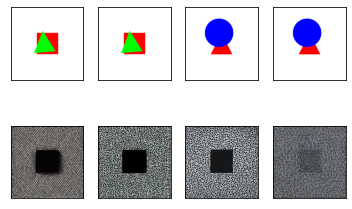

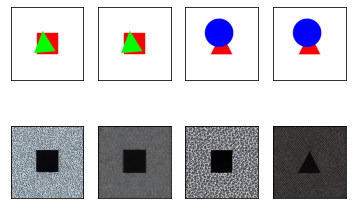

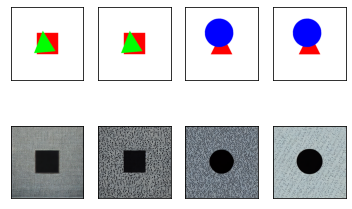

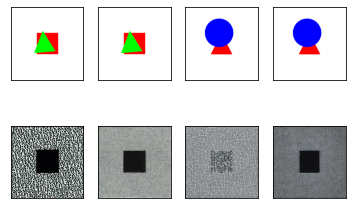

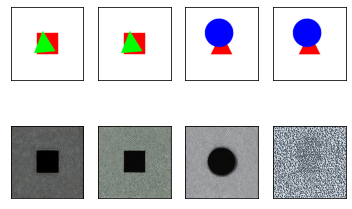

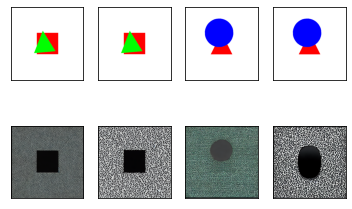

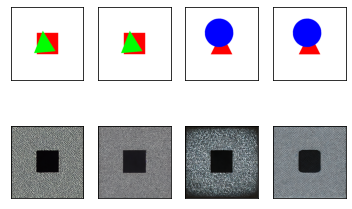

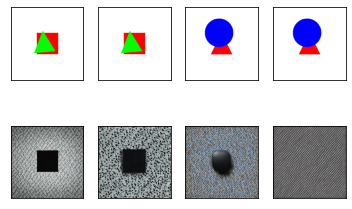

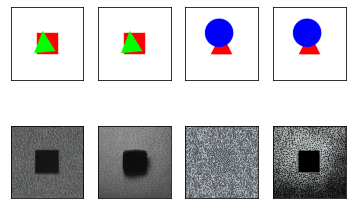

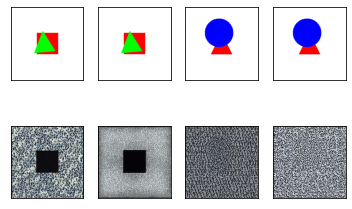

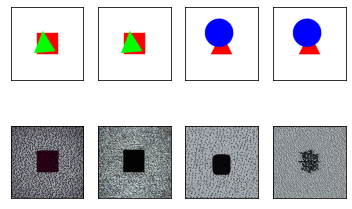

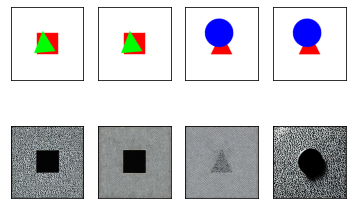

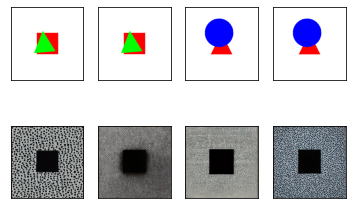

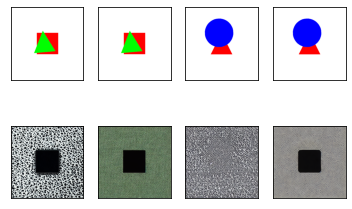

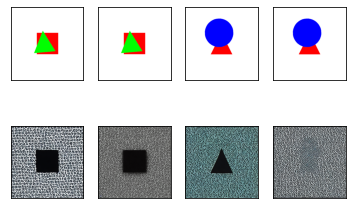

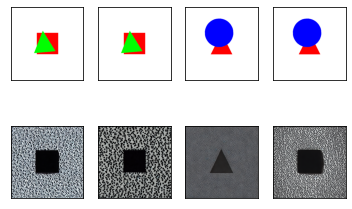

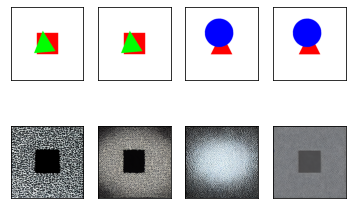

In [71]:
## https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet.py
#Set number of max train steps?
args.max_train_steps = args.num_train_epochs * len(train_dataloader)


# Train!
total_batch_size = args.train_batch_size #* accelerator.num_processes * args.gradient_accumulation_steps

print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num batches each epoch = {len(train_dataloader)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Instantaneous batch size per device = {args.train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    # disable=not accelerator.is_local_main_process,
)

weight_dtype = torch.float32
image_logs = None
for epoch in range(first_epoch, args.num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        #### Convert images to latent space
        #network that goes from four to three dimensions
        # contract_in = contract_layer()
        # print('calculting latents')
        latents = vae.encode(batch["pixel_values"][:,0,:].squeeze().to(dtype=weight_dtype).to('cuda')).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        # print('Latents calculated')
        
        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        #Following two lines are for uneven sampling (see t2i section 3.4)
        timesteps = (1 - (timesteps/ noise_scheduler.config.num_train_timesteps)**3) *  noise_scheduler.config.num_train_timesteps
        timesteps = timesteps.to(torch.int).clip(0,noise_scheduler.config.num_train_timesteps-1).to(latents.device).long()
        # print(timesteps)
        # timesteps = timesteps.long()
        # print('Noise Generated')

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        prompt_embeds = pipe._encode_prompt(
            "picture of an object on a white background",
            device="cuda",
            num_images_per_prompt = args.train_batch_size ,
            do_classifier_free_guidance=args.do_classifier_free_guidance,
            negative_prompt=None,
            prompt_embeds=None,
            negative_prompt_embeds=None,
        )
        # print('Prompt Embeddings Generated')

        # Denoising loop
        adapter_input = batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda')
        adapter_state = adapter(adapter_input)
        for k, v in enumerate(adapter_state):
            adapter_state[k] = v * args.adapter_conditioning_scale
        if args.num_images_per_prompt > 1:
            for k, v in enumerate(adapter_state):
                adapter_state[k] = v.repeat(args.num_images_per_prompt, 1, 1, 1)
        if args.do_classifier_free_guidance:
            for k, v in enumerate(adapter_state):
                adapter_state[k] = torch.cat([v] * 2, dim=0)
        # print('Adapter values Generated')

        
        ## expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([noisy_latents] * 2) if args.do_classifier_free_guidance else noisy_latents

        # predict the noise residual
        noise_pred = unet(
                latent_model_input,
                timesteps,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
                down_block_additional_residuals=[state.clone() for state in adapter_state],
        ).sample

        # print('Prediction complete')
        # Get the target for loss depending on the prediction type
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
        loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
        # print('loss computed')
        loss.backward()
        optimizer.step()
        unet_optim.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none=args.set_grads_to_none)
        unet_optim.zero_grad(set_to_none=args.set_grads_to_none)
        progress_bar.update(1)

    logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
    print(logs)
    
    progress_bar.set_postfix(**logs)
    if epoch % 2 == 0:
        val_out = log_validation(pipe, adapter, args)
        save_image_logs(val_out,step=epoch)
    if global_step >= args.max_train_steps:
        break

## Masking with a different shape

Text(0.5, 1.0, 'Input image')

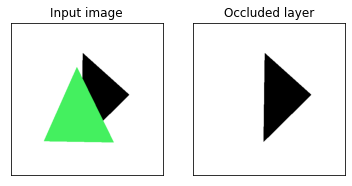

In [121]:
plt.figure()
plt.subplot(122)
img,out_pts,normals = generate_triangle_sdf(H,W)
img = 1 - img
first_img = (np.repeat(img,3,-1)* 255).astype(np.uint8)
plt.imshow(first_img)
plt.xticks([]); plt.yticks([])
mask_img,_,_ = generate_triangle_sdf(H,W)
# _,mask_img,_ = create_polygon(center, min_radius, max_radius, H=H,W=W)
mask_img = mask_img.astype(int)
plt.title('Occluded layer')
masked_img = np.copy(img)
masked_img[mask_img==1] = .5

masked_img = gray2rgb(masked_img)
masked_img[np.all(masked_img==[127,127,127],axis=2)] = np.random.randint(0,255,3).astype(np.uint8)
plt.subplot(121)
plt.imshow(masked_img)
plt.xticks([]); plt.yticks([])
plt.title('Input image')

In [122]:
val_img = Image.fromarray(masked_img)

In [125]:
with torch.autocast("cuda"):
    image = pipe(args.validation_prompt, val_img, num_inference_steps=40, generator=None).images[0]


  0%|          | 0/40 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/pyplot.py:2724 in imshow                                                               │
│                                                                                                  │
│   2721 │   │   alpha=None, vmin=None, vmax=None, origin=None, extent=None, *,                    │
│   2722 │   │   filternorm=True, filterrad=4.0, resample=None, url=None,                          │
│   2723 │   │   data=None, **kwargs):                                                             │
│ ❱ 2724 │   __ret = gca().imshow(                                                                 │
│   2725 │   │   X, cmap=cmap, norm=norm, aspect=aspect,                                           │
│   2726 │   │   interpolation=interpolation, alpha=alpha, vmin=vmin,                              │
│   2727 │   │   vmax=vmax, origin=origin, extent=extent,                                          │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/__init__.py:1447 in inner                                                              │
│                                                                                                  │
│   1444 │   @functools.wraps(func)                                                                │
│   1445 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1446 │   │   if data is None:                                                                  │
│ ❱ 1447 │   │   │   return func(ax, *map(sanitize_sequence, args), **kwargs)                      │
│   1448 │   │                                                                                     │
│   1449 │   │   bound = new_sig.bind(ax, *args, **kwargs)                                         │
│   1450 │   │   auto_label = (bound.arguments.get(label_namer)                                    │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/axes/_axes.py:5523 in imshow                                                           │
│                                                                                                  │
│   5520 │   │   │   │   │   │   │     filternorm=filternorm, filterrad=filterrad,                 │
│   5521 │   │   │   │   │   │   │     resample=resample, **kwargs)                                │
│   5522 │   │                                                                                     │
│ ❱ 5523 │   │   im.set_data(X)                                                                    │
│   5524 │   │   im.set_alpha(alpha)                                                               │
│   5525 │   │   if im.get_clip_path() is None:                                                    │
│   5526 │   │   │   # image does not already have clipping set, clip to axes patch                │
│                                                                                                  │
│ /n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/m │
│ atplotlib/image.py:711 in set_data                                                               │
│                                                                                                  │
│    708 │   │                                               

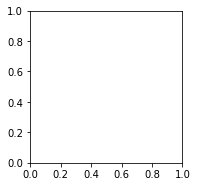

In [103]:
plt.subplot(121)
plt.imshow((np.repeat(masked_img,3,-1)* 255).astype(np.uint8),cmap='gray_r')
plt.xticks([]); plt.yticks([])
plt.title('Input image')

plt.subplot(122)
plt.imshow(image)
plt.title('Output Image')
plt.xticks([]); plt.yticks([]);

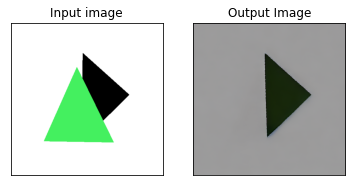

In [126]:
plt.subplot(121)
plt.imshow(masked_img)
plt.xticks([]); plt.yticks([])
plt.title('Input image')

plt.subplot(122)
plt.imshow(image)
plt.title('Output Image')
plt.xticks([]); plt.yticks([]);